In [1]:
import os
os.environ["CUDE_DEVICE_ORDER"] = "PCI_B_US_ID"
os.environ["CUDA_VISIBLE_DEVICES"] ="3"
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from itertools import product
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))


In [3]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)


In [4]:
def gen_balanced_pixel_locations(image_datasets, label_dataset, amount_of_labels, train_amount, val_amount, test_amount, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    

    pixels = []
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1
    outProj = Proj(label_dataset.crs)
    buffer = math.ceil(tile_size/2)
    total_pixels = train_amount + val_amount + test_amount
    total_count_per_dataset = math.ceil(total_pixels / len(image_datasets))
    bucket_size = math.ceil(total_pixels / (amount_of_labels - 7)) # - 7 because not enough pixels per bucket
    label_buckets = np.zeros(amount_of_labels)
    
    for index, image_dataset in enumerate(image_datasets):
        
        img_height, img_width = image_dataset.shape
        points = set()
        #all_points = list(itertools.product(range(0+buffer,img_width-buffer),range(0+buffer,img_height-buffer))) just a test to see whats faster
        while len(points) != total_count_per_dataset:
            #aPoint = all_points.pop(random.randint(0,len(all_points))) test to see what's faster
            aPoint = (random.randint(0+buffer, img_width-buffer), random.randint(0+buffer, img_height-buffer))
            c, r = aPoint
            (x, y) = image_dataset.xy(r, c)
            inProj = Proj(image_dataset.crs)
            if inProj != outProj:
                x,y = transform(inProj,outProj,x,y)
                # reference gps in label_image
            row, col = label_dataset.index(x,y)
            label = label_image[:, row, col]
            if label_buckets[label] != bucket_size and label != 1 and label != 0:
                past_size = len(points)
                points.add(aPoint)
                if past_size != len(points):
                    label_buckets[label] +=1
        points = zip(points, [index]*total_count_per_dataset)
        pixels += points
    random.shuffle(pixels)
    test_px = pixels[:test_amount]
    val_px = pixels[test_amount:(val_amount+test_amount)]
    train_px = pixels[(val_amount+test_amount):]
    return (train_px, val_px, test_px)

In [5]:
label_image = label_dataset.read()
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))


# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(64, 64, 7)


In [6]:
(train_px, val_px, test_px) = gen_balanced_pixel_locations(landsat_datasets, label_dataset, num_classes, 150000, 50000, 10000, tile_side)

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [8]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
batch_size = 25
epochs = 100
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

In [11]:
model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/100
6000/6000 [==============================] - 325s 54ms/step - loss: 2.2018 - acc: 0.2318 - val_loss: 2.0822 - val_acc: 0.2669
Epoch 2/100
6000/6000 [==============================] - 312s 52ms/step - loss: 2.0804 - acc: 0.2687 - val_loss: 1.9946 - val_acc: 0.2990
Epoch 3/100
6000/6000 [==============================] - 310s 52ms/step - loss: 2.0053 - acc: 0.2944 - val_loss: 1.9392 - val_acc: 0.3138
Epoch 4/100
6000/6000 [==============================] - 307s 51ms/step - loss: 1.9361 - acc: 0.3187 - val_loss: 1.8971 - val_acc: 0.3318
Epoch 5/100
6000/6000 [==============================] - 308s 51ms/step - loss: 1.8887 - acc: 0.3329 - val_loss: 1.8578 - val_acc: 0.3430
Epoch 6/100
6000/6000 [==============================] - 313s 52ms/step - loss: 1.8510 - acc: 0.3461 - val_loss: 1.8065 - val_acc: 0.3586
Epoch 7/100
6000/6000 [==============================] - 319s 53ms/step - loss: 1.8185 - acc: 0.3572 - val_loss: 1.7873 - val_acc: 0.3663
Epoch 8/100
6000/6000 [===========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6000/6000 [==============================] - 288s 48ms/step - loss: 1.2878 - acc: 0.5410 - val_loss: 1.7372 - val_acc: 0.4089
Epoch 26/100
3398/6000 [===============>..............] - ETA: 1:34 - loss: 1.2628 - acc: 0.5486

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6000/6000 [==============================] - 288s 48ms/step - loss: 1.2223 - acc: 0.5644 - val_loss: 1.7560 - val_acc: 0.4007
Epoch 28/100
6000/6000 [==============================] - 288s 48ms/step - loss: 1.1894 - acc: 0.5761 - val_loss: 1.8008 - val_acc: 0.3991
Epoch 29/100
6000/6000 [==============================] - 288s 48ms/step - loss: 1.1603 - acc: 0.5853 - val_loss: 1.7756 - val_acc: 0.4128
Epoch 30/100
6000/6000 [==============================] - 290s 48ms/step - loss: 1.1291 - acc: 0.5954 - val_loss: 1.8497 - val_acc: 0.3994
Epoch 31/100
6000/6000 [==============================] - 287s 48ms/step - loss: 1.1034 - acc: 0.6047 - val_loss: 1.8233 - val_acc: 0.4053
Epoch 32/100
6000/6000 [==============================] - 286s 48ms/step - loss: 1.0707 - acc: 0.6173 - val_loss: 1.8584 - val_acc: 0.4020
Epoch 33/100
6000/6000 [==============================] - 291s 48ms/step - loss: 1.0490 - acc: 0.6241 - val_loss: 1.8327 - val_acc: 0.4079
Epoch 34/100
6000/6000 [================

6000/6000 [==============================] - 296s 49ms/step - loss: 0.5048 - acc: 0.8214 - val_loss: 2.2128 - val_acc: 0.4112
Epoch 87/100
6000/6000 [==============================] - 301s 50ms/step - loss: 0.5003 - acc: 0.8227 - val_loss: 2.2367 - val_acc: 0.4162
Epoch 88/100
6000/6000 [==============================] - 296s 49ms/step - loss: 0.4964 - acc: 0.8238 - val_loss: 2.1596 - val_acc: 0.4176
Epoch 89/100
6000/6000 [==============================] - 289s 48ms/step - loss: 0.4957 - acc: 0.8241 - val_loss: 2.2103 - val_acc: 0.4133
Epoch 90/100
6000/6000 [==============================] - 292s 49ms/step - loss: 0.4897 - acc: 0.8261 - val_loss: 2.2265 - val_acc: 0.4133
Epoch 91/100
6000/6000 [==============================] - 293s 49ms/step - loss: 0.4856 - acc: 0.8284 - val_loss: 2.1690 - val_acc: 0.4152
Epoch 92/100
6000/6000 [==============================] - 291s 48ms/step - loss: 0.4815 - acc: 0.8292 - val_loss: 2.2577 - val_acc: 0.4093
Epoch 93/100
6000/6000 [================

In [17]:
predict = model.predict_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, test_px, batch_size), 
                    steps=len(test_px) // batch_size, verbose=1)

400/400 [==============================] - 21s 53ms/step


In [15]:
eval_generator = generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, test_px, batch_size=1)

In [18]:
labels = np.empty(predict.shape)
count = 0
while count < len(test_px):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count+=1

In [19]:
labels.shape

(10000, 23)

In [22]:
label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predict, axis=1)

In [23]:
label_index[:10]

array([ 3, 20,  8,  9,  7, 11, 13,  2, 15, 14])

In [24]:
pred_index[:10]

array([ 3,  6,  8, 11,  7, 15, 11,  2, 12, 12])

In [25]:
correct_predictions = np.zeros(pred_index.shape)
correct_predictions[label_index == pred_index] = 1

In [26]:
correct_predictions[:20]

array([1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.])

In [27]:
np.count_nonzero(correct_predictions) / len(test_px)

0.4242

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

In [35]:
conf_matrix = confusion_matrix(label_index, pred_index)

In [31]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


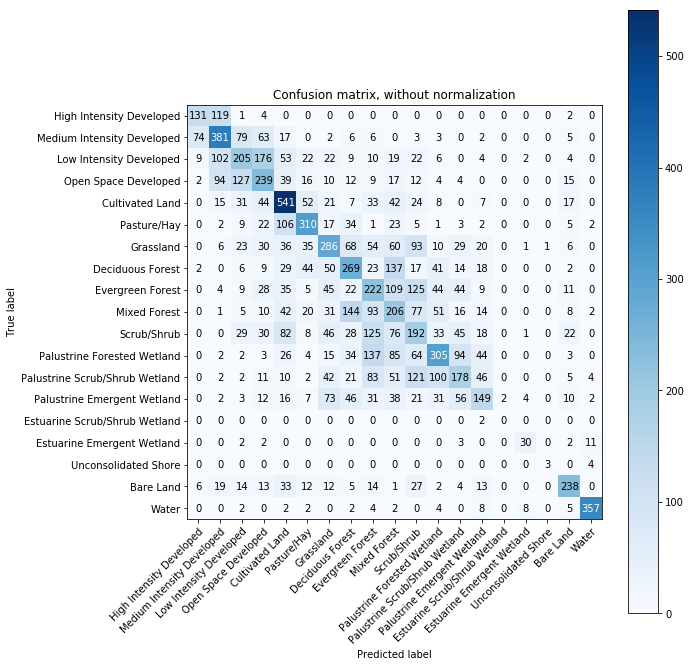

In [36]:
np.set_printoptions(precision=2)
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)), class_dict=class_names)

In [12]:
#USING BALANCED
train_buckets = np.zeros(num_classes)
for i in range(len(train_px)):
        c, r = train_px[i][0]
        (x, y) = landsat_datasets[train_px[i][1]].xy(r, c) 
        outProj = Proj(label_dataset.crs)
        inProj = Proj(landsat_datasets[train_px[i][1]].crs)
         #print(train_label_buckets)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
             # reference gps in label_image
        row, col = label_dataset.index(x,y)
        label = label_image[:, row, col]
        train_buckets[label] +=1
print("TRAINING BUCKETS")
print(train_buckets)
val_buckets = np.zeros(num_classes)
for i in range(len(val_px)):
        c, r = val_px[i][0]
        (x, y) = landsat_datasets[val_px[i][1]].xy(r, c) 
        outProj = Proj(label_dataset.crs)
        inProj = Proj(landsat_datasets[val_px[i][1]].crs)
         #print(train_label_buckets)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
             # reference gps in label_image
        row, col =  label_dataset.index(x,y)
        label = label_image[:, row, col]
        val_buckets[label] +=1
print("VALIDATION BUCKETS")
print(val_buckets)
test_buckets = np.zeros(num_classes)
for i in range(len(test_px)):
        c, r = test_px[i][0]
        (x, y) = landsat_datasets[test_px[i][1]].xy(r, c) 
        outProj = Proj(label_dataset.crs)
        inProj = Proj(landsat_datasets[test_px[i][1]].crs)
         #print(train_label_buckets)
        if inProj != outProj:
            x,y = transform(inProj,outProj,x,y)
             # reference gps in label_image
        row, col =  label_dataset.index(x,y)
        label = label_image[:, row, col]
        test_buckets[label] +=1
print("TEST BUCKETS")
print(test_buckets)

TRAINING BUCKETS
[   0.    0. 3670. 8998. 9438. 9387. 9300. 9345. 9332. 9368. 9323. 9384.
 9398. 9380. 9404. 9408.   12.  297. 5428.  632. 9126. 9355.   15.]
VALIDATION BUCKETS
[0.000e+00 0.000e+00 1.258e+03 2.887e+03 3.067e+03 3.134e+03 3.173e+03
 3.121e+03 3.134e+03 3.117e+03 3.206e+03 3.143e+03 3.123e+03 3.104e+03
 3.130e+03 3.085e+03 5.000e+00 1.200e+02 1.786e+03 2.300e+02 3.027e+03
 3.147e+03 3.000e+00]
TEST BUCKETS
[  0.   0. 242. 612. 620. 604. 652. 659. 659. 640. 596. 598. 604. 641.
 591. 632.   1.  20. 361.  45. 599. 623.   1.]
